In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os

import uproot

import histlite as hl

import scipy.interpolate as interp

from scipy.optimize import curve_fit


plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10,8)

/cvmfs/lz.opensciencegrid.org/external/Python/3.8.2/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
replayed_data_dir = '/global/cfs/cdirs/lux/users/haselsco/TUNL_August_2021_Data/replayed/slurm_run30235/'

replay_period = 12800. # ns, period used in replay processing of the data
escale_pmt = 0.6219 # keV/PH, from Ba-133 cal fit
escale_sipm = 0.1868 # keV/PH, from Ba-133 cal fit

rootfiles = [filename for filename in os.listdir(replayed_data_dir) if filename.endswith('.root')]


In [3]:
data_list_gamma = []
data_list_ndet = []
data_list_coin = []

n_open = 50

print('{} files found.'.format(len(rootfiles)))
print('only opening {} of these...'.format(n_open))
for i,thisfile in enumerate(rootfiles[:n_open]):
    if i % 10 == 0:
        print('Opening {} of {}'.format(i,len(rootfiles)))
    
    fullpath = replayed_data_dir + thisfile
    
    data_list_gamma.append( uproot.open(fullpath)['gamma_events'].arrays( ["*"], outputtype=pd.DataFrame ) )
    data_list_ndet.append( uproot.open(fullpath)['ndet_events'].arrays( ["*"], outputtype=pd.DataFrame ) )
    #data_list_coin.append( uproot.open(fullpath)['ndet_coin_events'].arrays( ["*"], outputtype=pd.DataFrame ) )
    
    


223 files found.
only opening 50 of these...
Opening 0 of 223
Opening 10 of 223
Opening 20 of 223
Opening 30 of 223
Opening 40 of 223


In [5]:
gdata = pd.concat(data_list_gamma,ignore_index=True)
ndata = pd.concat(data_list_ndet,ignore_index=True)
#cdata = pd.concat(data_list_coin,ignore_index=True)

#cdata.head(10)
ndata.head()
#print( ndata.index, ' ndet events' )

ndet_ch  ndet_PH  ndet_E       ndet_ts      ndet_tof  ndet_PSD  \
0     18.0   2683.0     0.0  6.784935e+11  10854.649931  4.813105   
1      7.0  16383.0     0.0  6.785231e+11   2697.003942  6.233589   
2     19.0   4458.0     0.0  6.785350e+11  12101.729161  4.034536   
3     17.0    989.0     0.0  6.785662e+11   7967.966027  9.521426   
4      8.0   1401.0     0.0  6.785663e+11   8856.263189  5.174386   

   ndet_PSD_cut  ndet_flash  ndet_true_time  
0          9.50      2436.0     8418.649931  
1          8.50      2452.0      245.003942  
2          9.00      2448.0     9653.729161  
3         10.50      2450.0     5517.966027  
4          7.25      2483.0     6373.263189

In [26]:
#ch1_mask = (ndata['ndet_ch'] == 1) & (ndata['ndet_PH'] < 15000)
ch1_mask = ndata['ndet_PH'] < 15000
ndet1data = ndata.loc[ch1_mask]

pmt_mask = gdata['gamma_ch'] == 27
data_pmt = gdata.loc[pmt_mask]

nts_array = np.array([])
gts_array = np.array([])
dts_array = np.array([])

num_nts = ndet1data['ndet_ts'].count()
num_gts = data_pmt['gamma_ts'].count()
print( 'there are {} neutron time stamps'.format(num_nts) )
print( 'there are {} PMT NaI time stamps'.format(num_nts) )

nts_array = np.zeros(num_nts)
gts_array = np.zeros(num_nts)
dts_array = np.zeros(num_nts)

prev_nts = 0.
for i,nts in enumerate(ndet1data['ndet_ts']):
    if i % 10 == 0:
        print('on TS number {}'.format(i))
    
    gamma_ts = data_pmt['gamma_ts'].to_numpy()
    ts_idx = gamma_ts.searchsorted( nts )
    gts = gamma_ts[ts_idx]
    
    print('{} sec have passed since last ndet evt'.format((nts-prev_nts)*1e-9))
    print('index is {}'.format(ts_idx))
    print('ndet TS is {}'.format(nts))
    print('PMT TS is {}\n'.format(gts))
    
    #ts_idx = data_pmt['gamma_ts'].searchsorted( nts )
    #gts = data_pmt['gamma_ts'].at( ts_idx )
    
    nts_array[i] = nts
    gts_array[i] = gts
    dts_array[i] = nts-gts
    #np.append(nts_array, nts)
    #np.append(gts_array, gts)
    #np.append(dts_array, nts-gts)
    prev_nts = nts


there are 25462 neutron time stamps
there are 25462 PMT NaI time stamps
on TS number 0
678.4935040390956 sec have passed since last ndet evt
index is 2187251
ndet TS is 678493504039.0956
PMT TS is 2145638349486.439

0.041454584231567386 sec have passed since last ndet evt
index is 2187251
ndet TS is 678534958623.3271
PMT TS is 2145638349486.439

0.031253868126098636 sec have passed since last ndet evt
index is 2187251
ndet TS is 678566212491.4532
PMT TS is 2145638349486.439

0.00010328829418945313 sec have passed since last ndet evt
index is 2187251
ndet TS is 678566315779.7474
PMT TS is 2145638349486.439

0.06440186687011719 sec have passed since last ndet evt
index is 2187251
ndet TS is 678630717646.6176
PMT TS is 2145638349486.439

0.03723974246337891 sec have passed since last ndet evt
index is 2187251
ndet TS is 678667957389.0809
PMT TS is 2145638349486.439

0.005644238807250977 sec have passed since last ndet evt
index is 2187251
ndet TS is 678673601627.8882
PMT TS is 21456383494

IndexError: index 6812596 is out of bounds for axis 0 with size 6812596

In [24]:
print( dts_array )

[-1.46683044e+12 -1.46682329e+12 -1.46620386e+12 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


Text(0, 0.5, 'Events')

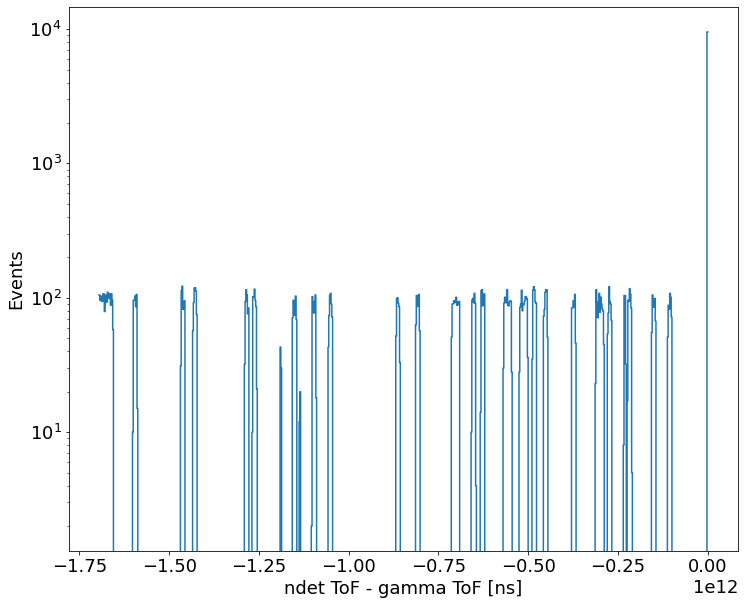

In [28]:
plt.figure(figsize=(12,10))
r=(-12800,12800)
h_dt = hl.hist( dts_array , bins=800)
hl.plot1d(h_dt)
plt.yscale('log')
plt.xlabel('ndet ToF - gamma ToF [ns]')
plt.ylabel('Events')
#plt.xlim(-5000.,5000)

In [6]:
gmask_pmt = gdata['gamma_ch'] == 27

cmask_pmt = cdata['gamma_ch_coin'] == 27

gdata_pmt = gdata.loc[gmask_pmt]

cdata_pmt = cdata.loc[cmask_pmt]

cdata_pmt.head()


ndet_ch_coin  gamma_ch_coin  ndet_PH_coin  gamma_PH_coin  ndet_E_coin  \
1          27.0           27.0    522.733333     522.733333          0.0   
3          27.0           27.0   1132.575000    1132.575000          0.0   
4          30.0           27.0   2916.975000     387.658333          0.0   
6          30.0           27.0    515.841667     149.383333          0.0   
9          27.0           27.0    146.808333     146.808333          0.0   

   ndet_ts_coin  gamma_ts_coin  ndet_tof_coin  gamma_tof_coin  ndet_PSD_coin  \
1  6.784895e+11   6.784895e+11   11566.517642    11566.517642            8.0   
3  6.784895e+11   6.784895e+11    2770.173553     2770.173553            8.0   
4  6.784895e+11   6.784895e+11    3786.915984     3477.486297            8.0   
6  6.784895e+11   6.784895e+11    6273.950774     6711.223479            8.0   
9  6.784895e+11   6.784895e+11    9387.967742     9387.967742            8.0   

   ndet_PSD_cut_coin  ndet_del_time_coin  ndet_true_time_coin  \
1                0.0            0.000000         11566.517642   
3                0.0            0.000000          2770.173553   
4                0.0         -307.289917          3786.915984   
6                0.0         -100.639771          6273.950774   
9                0.0            0.000000          9387.967742   

   gamma_true_time_coin  ndet_flash_coin  gamma_flash_coin  gamma_t10_coin  \
1          11566.517642              0.0               0.0           144.0   
3           2770.173553              0.0               0.0           100.0   
4           3477.486297              0.0               0.0             7.0   
6           6711.223479              0.0               0.0           131.0   
9           9387.967742              0.0               0.0           110.0   

   gamma_t25_coin  gamma_t50_coin  gamma_t90_coin  
1           213.0           308.0           463.0  
3           263.0           340.0           470.0  
4           212.0           414.0           444.0  
6           190.0           248.0           316.0  
9           154.0           248.0           391.0

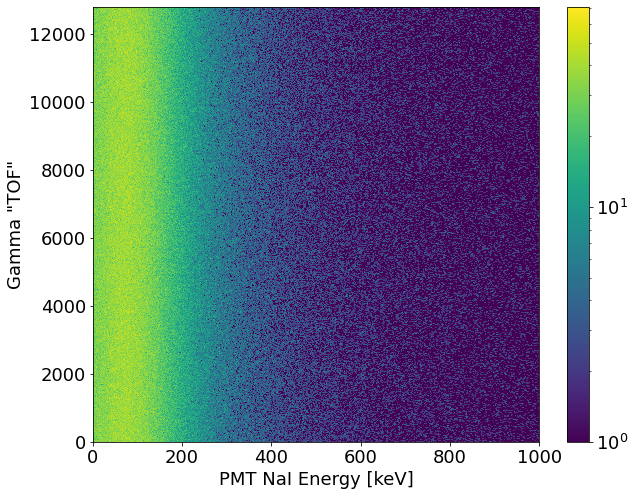

In [7]:
from matplotlib import colors

plt.hist2d( gdata_pmt['gamma_PH'] * escale_pmt,\
                 gdata_pmt['gamma_tof'], \
               bins=[np.linspace(0.,1000.,500),np.linspace(0.,replay_period,3200)],\
                            norm=colors.LogNorm() )
plt.xlabel('PMT NaI Energy [keV]')
plt.ylabel('Gamma \"TOF\"')
plt.xlim(0.,1000.)
plt.colorbar()

Text(0, 0.5, 'Events')

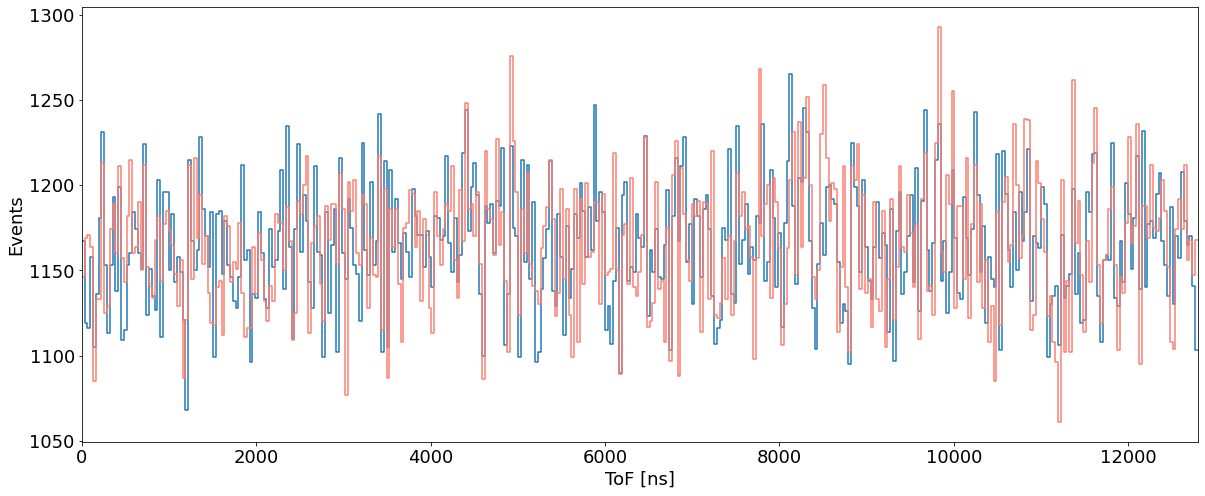

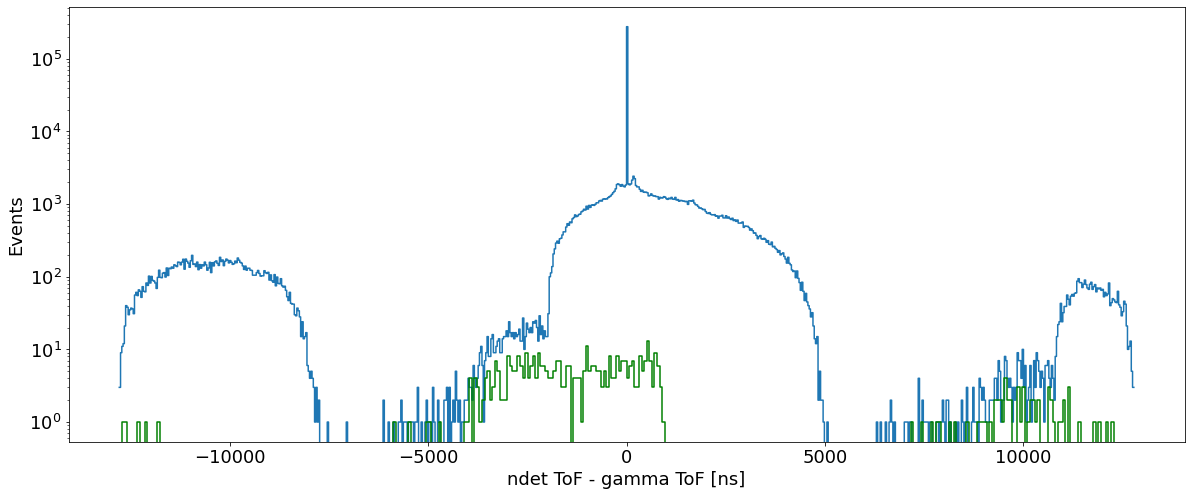

In [40]:
mask = (cdata_pmt['gamma_t25_coin']>75.)&(cdata_pmt['gamma_t25_coin']<100.)&\
        (cdata_pmt['gamma_t50_coin'] - cdata_pmt['gamma_t10_coin']>15)&\
        (cdata_pmt['gamma_t50_coin'] - cdata_pmt['gamma_t10_coin']<55)

ndet_mask = (cdata_pmt['ndet_ch_coin']==0) | (cdata_pmt['ndet_ch_coin']==1) | (cdata_pmt['ndet_ch_coin']==2)

fig1, ax1 = plt.subplots(1, figsize=(20,8))
h_gtof = hl.hist(cdata_pmt['gamma_tof_coin'].loc[mask], bins=np.linspace(0.,replay_period,400))
h_ntof = hl.hist(cdata_pmt['ndet_tof_coin'].loc[mask], bins=np.linspace(0.,replay_period,400))
hl.plot1d(ax1, h_gtof)
hl.plot1d(ax1, h_ntof,color='salmon')
plt.xlabel('ToF [ns]')
plt.ylabel('Events')
plt.xlim(0.,replay_period)

fig2, ax2 = plt.subplots(figsize=(20,8))
h_tof_diff = hl.hist( cdata_pmt['ndet_tof_coin'].loc[mask]-cdata_pmt['gamma_tof_coin'].loc[mask] , bins=800, range=(-12800,12800))
h_tof_diff2 = hl.hist( cdata_pmt['ndet_tof_coin'].loc[mask].loc[ndet_mask]-cdata_pmt['gamma_tof_coin'].loc[mask].loc[ndet_mask] , bins=400, range=(-12800,12800))
hl.plot1d(ax2,h_tof_diff)
hl.plot1d(ax2,h_tof_diff2,color='g')
plt.yscale('log')
plt.xlabel('ndet ToF - gamma ToF [ns]')
plt.ylabel('Events')
#plt.xlim(-5000.,5000)


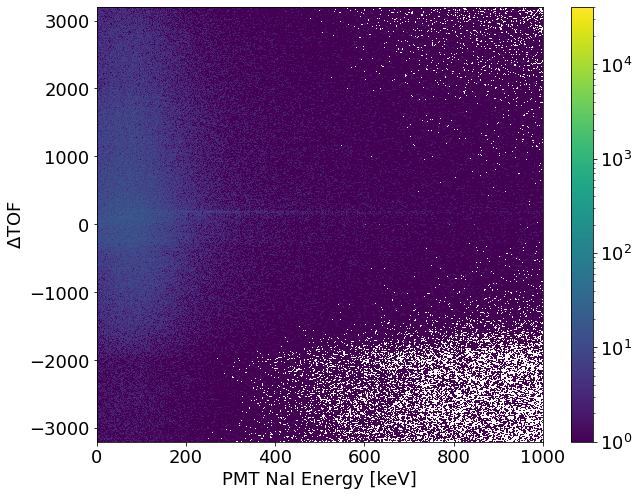

In [10]:
from matplotlib import colors

plt.hist2d( cdata_pmt['gamma_PH_coin'] * escale_pmt,\
                 np.fmod(cdata_pmt['ndet_tof_coin']-cdata_pmt['gamma_tof_coin'],3200), \
               bins=[np.linspace(0.,1000.,1000),np.linspace(-3200,3200,3200)],\
                            norm=colors.LogNorm() )
plt.xlabel('PMT NaI Energy [keV]')
plt.ylabel(r'$\Delta$TOF')
plt.xlim(0.,1000.)
plt.colorbar()

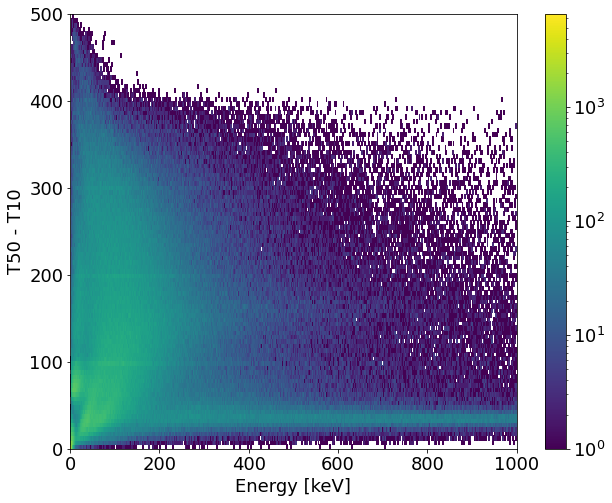

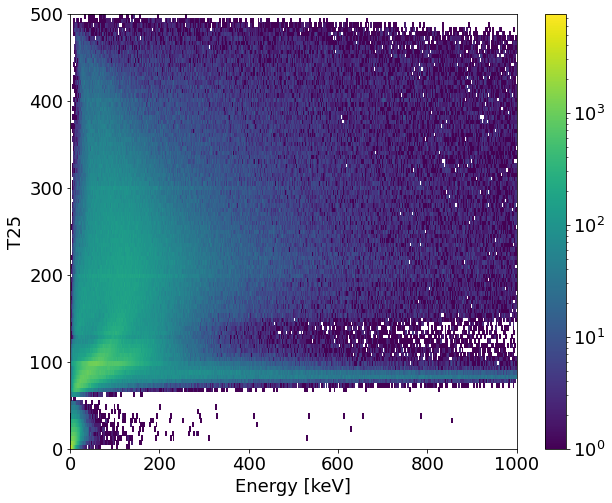

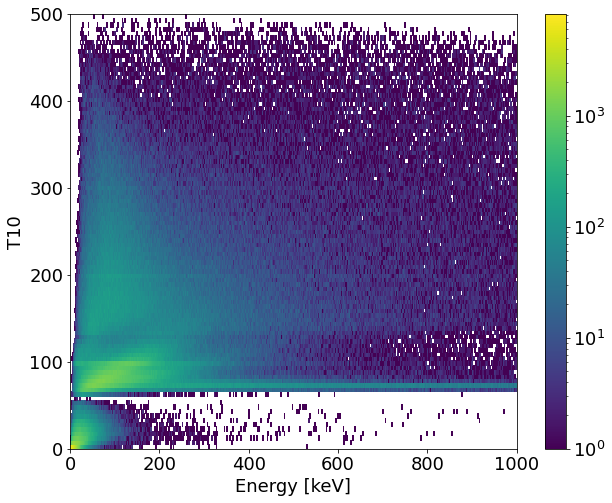

In [18]:
#mask = (data_pmt['gamma_tof']>2000.)&(data_pmt['gamma_tof']<10000.)

plt.hist2d( gdata_pmt['gamma_PH'] * escale_pmt,\
                 gdata_pmt['gamma_t50'] - gdata_pmt['gamma_t10'], \
               bins=[np.linspace(0.,1000.,500),np.linspace(0.,500,100)],\
                            norm=colors.LogNorm() )
plt.xlabel('Energy [keV]')
plt.ylabel('T50 - T10')
plt.xlim(0.,1000.)
#plt.ylim(0.,200.)
plt.colorbar()

plt.figure(2)
#mask = (data_pmt['gamma_tof']>2000.)&(data_pmt['gamma_tof']<10000.)

plt.hist2d( gdata_pmt['gamma_PH'] * escale_pmt,\
                 gdata_pmt['gamma_t25'], \
               bins=[np.linspace(0.,1000.,500),np.linspace(0.,500,100)],\
                            norm=colors.LogNorm() )
plt.xlabel('Energy [keV]')
plt.ylabel('T25')
plt.xlim(0.,1000.)
plt.colorbar()

plt.figure(3)
#mask = (data_pmt['gamma_tof']>2000.)&(data_pmt['gamma_tof']<10000.)

plt.hist2d( gdata_pmt['gamma_PH'] * escale_pmt,\
                 gdata_pmt['gamma_t10'], \
               bins=[np.linspace(0.,1000.,500),np.linspace(0.,500,100)],\
                            norm=colors.LogNorm() )
plt.xlabel('Energy [keV]')
plt.ylabel('T10')
plt.xlim(0.,1000.)
plt.colorbar()


(0.0, 3200.0)

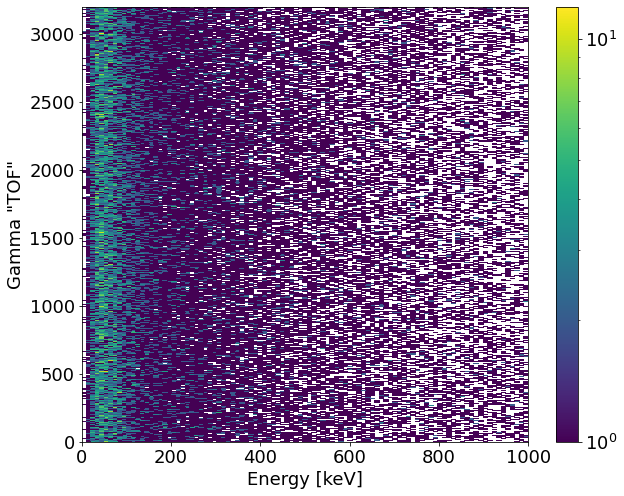

In [ ]:
mask = (gdata_pmt['gamma_t25']>75.)&(gdata_pmt['gamma_t25']<100.)&\
        (data_pmt['gamma_t50'] - data_pmt['gamma_t10']>15)&\
        (data_pmt['gamma_t50'] - data_pmt['gamma_t10']<55)

plt.hist2d( data_pmt['gamma_PH'].loc[mask] * escale_pmt,\
                 np.fmod(data_pmt['gamma_tof'].loc[mask]+400,3200.), \
               bins=[np.linspace(0.,1000.,100),np.linspace(0.,3200,3200)],\
                            norm=colors.LogNorm() )

TOFdata = np.fmod(data_pmt['gamma_tof']+400,3200.)

plt.xlabel('Energy [keV]')
plt.ylabel('Gamma \"TOF\"')
plt.xlim(0.,1000.)
plt.colorbar()
           
plt.ylim(0.,3200.)

(0.0, 200.0)

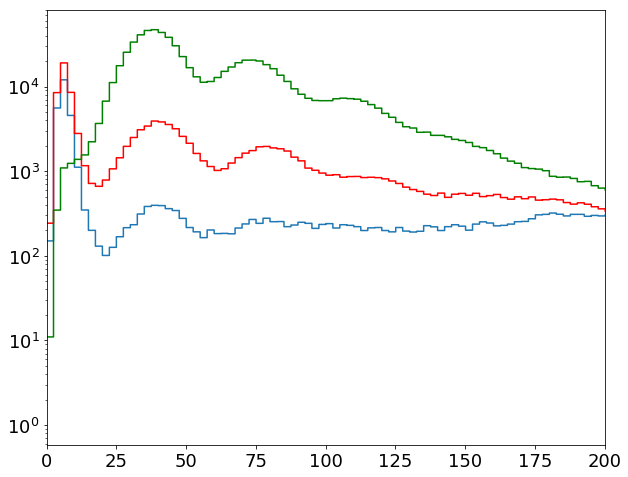

In [69]:
thismask = (data_pmt['gamma_t25']>75.)&(data_pmt['gamma_t25']<100.)&\
        (data_pmt['gamma_t50'] - data_pmt['gamma_t10']>15)&\
        (data_pmt['gamma_t50'] - data_pmt['gamma_t10']<55)&\
        (TOFdata>1800.)&(TOFdata<2400.)
    
h_delayed_energy = hl.hist(data_pmt['gamma_PH'].loc[thismask]*escale_pmt, bins=np.linspace(0.,2000.,800))

hl.plot1d(h_delayed_energy)

plt.yscale('log')





thismask = (data_pmt['gamma_t25']>75.)&(data_pmt['gamma_t25']<100.)&\
        (data_pmt['gamma_t50'] - data_pmt['gamma_t10']>15)&\
        (data_pmt['gamma_t50'] - data_pmt['gamma_t10']<55)&\
        (TOFdata>1000.)&(TOFdata<1500.)
    
h_delayed_energy2 = hl.hist(data_pmt['gamma_PH'].loc[thismask]*escale_pmt, bins=np.linspace(0.,2000.,800))

hl.plot1d(h_delayed_energy2,color='r')

plt.yscale('log')





thismask = (data_pmt['gamma_t25']>75.)&(data_pmt['gamma_t25']<100.)&\
        (data_pmt['gamma_t50'] - data_pmt['gamma_t10']>15)&\
        (data_pmt['gamma_t50'] - data_pmt['gamma_t10']<55)&\
        (TOFdata>80.)&(TOFdata<100.)
    
h_prompt_energy = hl.hist(data_pmt['gamma_PH'].loc[thismask]*escale_pmt, bins=np.linspace(0.,2000.,800))

hl.plot1d(h_prompt_energy,color='g')

plt.yscale('log')

plt.xlim(0.,200.)




In [39]:
for i, evt in cdata.iterrows():
    print(evt['ndet_ts_coin'], evt['gamma_ts_coin'], evt['ndet_ts_coin']-evt['gamma_ts_coin'])
    if i>10:
        break

678489471288.1356 678489471288.1356 0.0
678489471907.1128 678489471907.1128 0.0
678489475024.5714 678489474922.6737 101.897705078125
678489475024.5714 678489475024.5714 0.0
678489477796.3488 678489477489.0588 307.2899169921875
678489477796.3488 678489477796.3488 0.0
678489480286.2074 678489480185.5676 100.6397705078125
678489480286.2074 678489480286.2074 0.0
678489483012.7218 678489482883.2 129.5218505859375
678489483012.7218 678489483012.7218 0.0
678489488767.0416 678489485617.4 3149.6416015625
678489488767.0416 678489485951.0038 2816.037841796875


(25.0, 40.0)

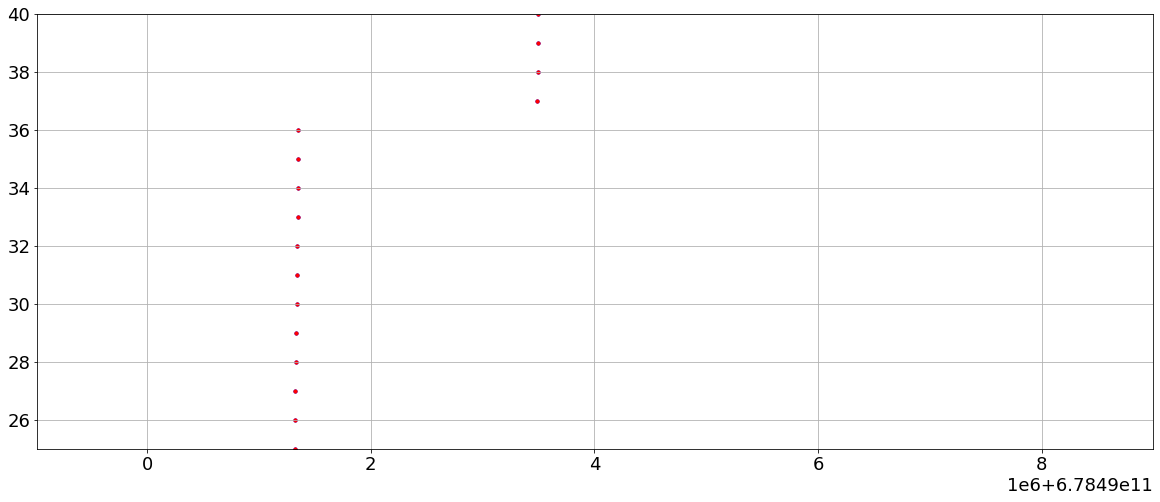

In [38]:
plt.figure(1,figsize=(20,8))
plt.scatter( cdata_pmt.head(100)['ndet_ts_coin'], range(100), s=10, color='blue')
plt.scatter( cdata_pmt.head(100)['gamma_ts_coin'], range(100), s=10, color='red')
plt.grid()
plt.ylim(25,40)

In [18]:
cdata_pmt.head(100)['ndet_ts_coin'].to_numpy()

array([6.78489472e+11, 6.78489475e+11, 6.78489478e+11, 6.78489480e+11,
       6.78489483e+11, 6.78489489e+11, 6.78489489e+11, 6.78489638e+11,
       6.78489641e+11, 6.78489644e+11, 6.78489647e+11, 6.78489648e+11,
       6.78489651e+11, 6.78489657e+11, 6.78489657e+11, 6.78490136e+11,
       6.78490140e+11, 6.78490143e+11, 6.78490146e+11, 6.78490149e+11,
       6.78490152e+11, 6.78490155e+11, 6.78491313e+11, 6.78491316e+11,
       6.78491318e+11, 6.78491321e+11, 6.78491323e+11, 6.78491326e+11,
       6.78491331e+11, 6.78491335e+11, 6.78491337e+11, 6.78491341e+11,
       6.78491343e+11, 6.78491346e+11, 6.78491348e+11, 6.78491354e+11,
       6.78491354e+11, 6.78493489e+11, 6.78493494e+11, 6.78493496e+11,
       6.78493500e+11, 6.78493502e+11, 6.78493505e+11, 6.78493509e+11,
       6.78494309e+11, 6.78494311e+11, 6.78494314e+11, 6.78494318e+11,
       6.78494320e+11, 6.78494323e+11, 6.78494328e+11, 6.78494716e+11,
       6.78494719e+11, 6.78494722e+11, 6.78494726e+11, 6.78494728e+11,
      

In [41]:
import pickle

datalist = []

for i in range(30):
    filename = replayed_data_dir + 'run30235_{}_nai_pmt_waveforms.pkl'.format(i)
    with open( filename ,'rb') as pklfile:
        datalist.extend(pickle.load(pklfile))
    
datadf = pd.DataFrame(datalist)


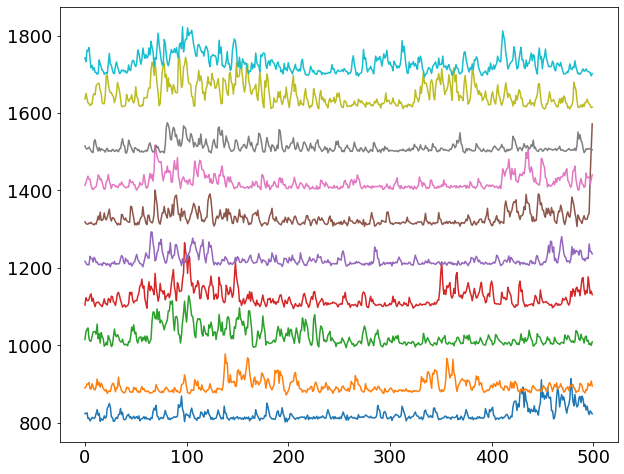

In [42]:
mask = (datadf['t50'] - datadf['t10']>15)&\
        (datadf['t50'] - datadf['t10']<55)&\
        (datadf['peakhigh_reported']* escale_pmt < 50)&\
        (datadf['peakhigh_reported']* escale_pmt > 30)
        

dfmask = datadf.loc[mask]

for i in range(10):
    try:
        plt.plot(dfmask['samples'].iloc[i] + 100*i)
    except IndexError:
        break

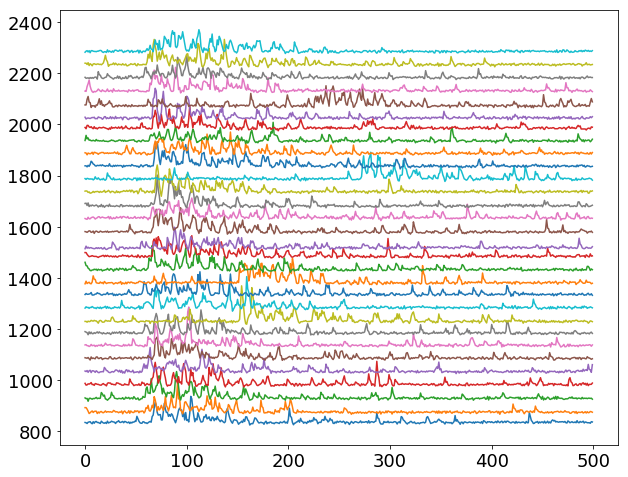

In [79]:
mask = (datadf['t50'] - datadf['t10']>15)&\
        (datadf['t50'] - datadf['t10']<55)&\
         (datadf['peakhigh_reported']* 0.6219 > 20)&\
         (datadf['peakhigh_reported']* 0.6219 < 50)
        

dfmask = datadf.loc[mask]

for i in range(30):
    try:
        plt.plot(dfmask['samples'].iloc[i] + 50*i)
    except IndexError:
        break

In [ ]:
mask = (datadf['t25']>75.)&(datadf['t25']<100.)&\
        (datadf['t50'] - datadf['t10']>75)&\
        (datadf['t50'] - datadf['t10']<125)&\
        (datadf['peakhigh_reported']* 0.6219 < 50)&\
        (datadf['peakhigh_reported']* 0.6219 > 30)
        

dfmask = datadf.loc[mask]

for i in range(10):
    try:
        plt.plot(dfmask['samples'].iloc[i] + 100*i)
    except IndexError:
        break